### A better utilization of dask delayed

In [3]:
from sqlalchemy import create_engine, text
from sqlalchemy.pool import NullPool
import random
import string
import numpy as np
import time
import platform
import os
import subprocess
from pathlib import Path
import glob
import multiprocessing as mp
import xarray
from random import randrange



NUM_RECORDS = 1000


#connect to sql
def get_urls():
	engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{ENDPOINT}/{SCHEMA}", poolclass=NullPool)
	temp_table = ( ''.join(random.choice(string.ascii_lowercase) for i in range(15))) 
	
	connection = engine.raw_connection()
	try:
		cursor_obj = connection.cursor()
		cursor_obj.execute(f'CREATE TEMPORARY TABLE {temp_table} SELECT {TABLE}.index FROM {SCHEMA}.{TABLE} WHERE IN_PROGRESS = 0 AND PROCESSED = 0 ORDER BY RAND() LIMIT {NUM_RECORDS}')
		cursor_obj.execute(f'UPDATE {SCHEMA}.{TABLE} SET IN_PROGRESS = 1, INSTANCE_ID = "{INSTANCE_ID}" WHERE {SCHEMA}.{TABLE}.index IN (SELECT {temp_table}.index FROM {temp_table})')
		cursor_obj.execute(f'SELECT {TABLE}.index, BASE_URL, GRANULE_ID FROM {SCHEMA}.{TABLE} WHERE {SCHEMA}.{TABLE}.index IN (SELECT {temp_table}.index FROM {temp_table})')
		results = cursor_obj.fetchall()
		cursor_obj.execute(f'DROP TABLE {temp_table}')
		cursor_obj.close()
	finally:
		connection.close()

	
	return results



In [31]:
def L2A(path, result):
	index = result[0]
	base_url = result[1]
	granule_id = result[2]

	l2a_path = f'{path}/{granule_id}'

	Path(l2a_path).mkdir(parents=True, exist_ok=True)
	

	base_url_granule = base_url+'/GRANULE/'+granule_id


	# using suprocess becasue gsutil creates a tempfile that other processes cannot open when using multiprocessing
	p = subprocess.Popen(['gsutil', 'cp', '-r', f'{base_url_granule}/IMG_DATA/R20m/*B12*', f'{l2a_path}'], cwd = l2a_path)

	p.wait()
	p.kill()
	
	return [index, l2a_path, granule_id]

In [35]:
def B12(l2a_path):
    B12_Path = glob.glob(f'{l2a_path}/*_B12*.jp2')[0]
    B12 = xarray.open_rasterio(B12_Path)[0].values
    return B12


def t08(B12):
    t08 = np.where(B12 >= 8000, 1, 0).sum()
    return t08
def t09(B12):
    t09 = np.where(B12 >= 9000, 1, 0).sum()
    return t09
def t10(B12):
    t10 = np.where(B12 >= 10000, 1, 0).sum()
    return r10
    
def t11(B12):
    t11 = np.where(B12 >= 11000, 1, 0).sum()
    return t11
def t12(B12):
    t12 = np.where(B12 >= 12000, 1, 0).sum()
    return t12
def t13(B12):
    t13 = np.where(B12 >= 13000, 1, 0).sum()
    return t13
    
def t14(B12):
    t14 = np.where(B12 >= 14000, 1, 0).sum()
    return t14
    
def t15(B12):
    t15 = np.where(B12 >= 15000, 1, 0).sum()
    return t15
    

In [40]:
def update_status(index, process_time, granule_id, t08, t09, t10, t11, t12, t13, t14, t15):
	stmt = f'UPDATE {TABLE} SET PROCESS_TIME = :total_time, PROCESSED = 1, T08 = :T08, T09= :T09, T10 = :T10, T11 = :T11, T12 = :T12, T13 = :T13, T14 = :T14, T15 = :T15 WHERE {TABLE}.index  = :index'

	values = {
		'total_time': process_time,
		'index': index,
		'T08': t08,
		'T09': t09,
		'T10': t10,
		'T11': t11,
		'T12': t12,
		'T13': t13,
		'T14': t14,
		'T15': t15
	}
	engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{ENDPOINT}/{SCHEMA}", poolclass=NullPool)
	with engine.begin() as conn:
		conn.execute(text(stmt), values)
		print(f'Insert {granule_id}')	

In [4]:
from dask import compute, delayed

In [45]:
results = ['test', 0,1,2]
PATH = 'test'
total_time = 0

In [46]:
a  = delayed(L2A)(PATH, *results)
b = delayed(B12)(a[1])
c08 = delayed(t08)(b)
c09 = delayed(t09)(b)
c10 = delayed(t10)(b)
c11 = delayed(t11)(b)
c12 = delayed(t12)(b)
c13 = delayed(t13)(b)
c14 = delayed(t14)(b)
c15 = delayed(t15)(b)

d = delayed(update_status)(a[0], total_time, a[2], c08, c09, c10, c11, c12, c13, c14, c15)

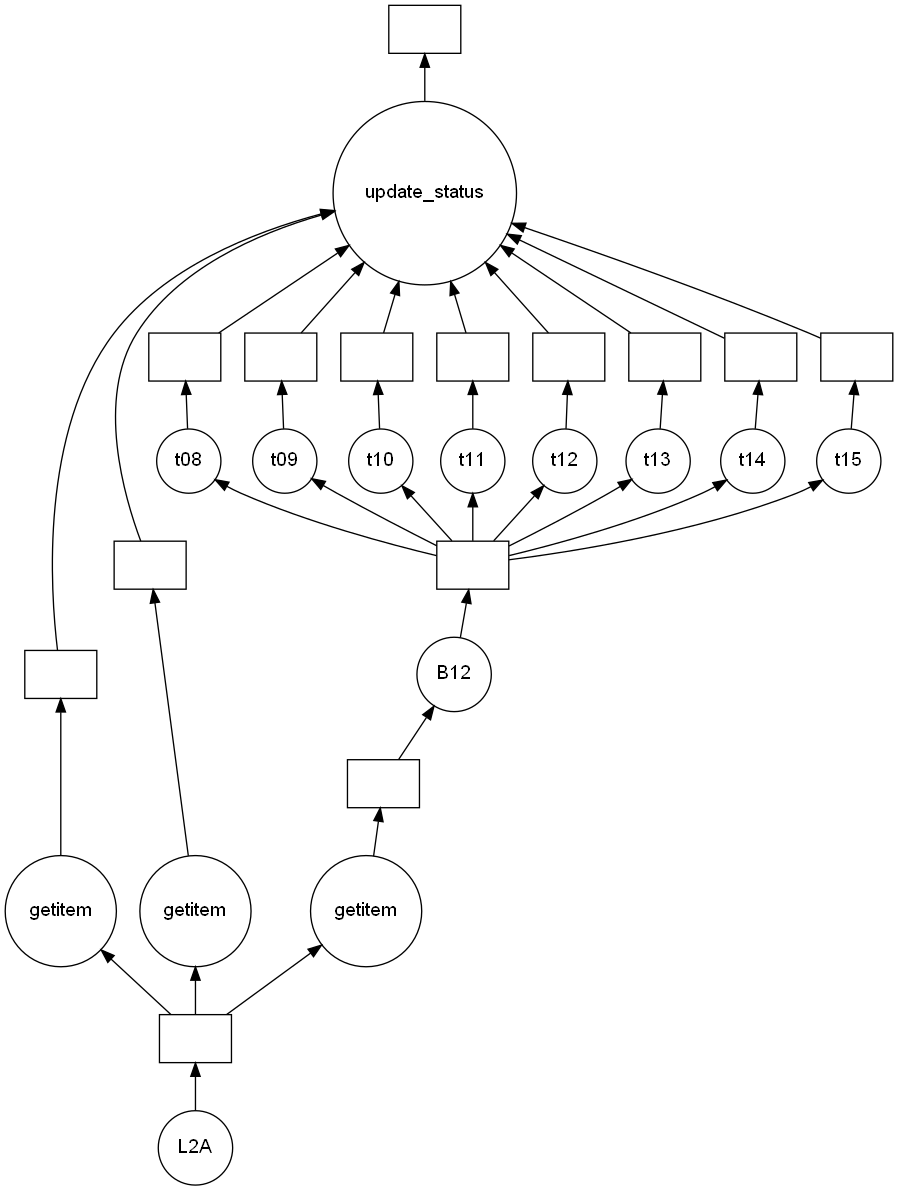

In [47]:
#still need to test and convert the atmopheric corrector to dask delayed
d.visualize()